In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt
import time

def read_geocsv(*args, **kwargs):
    df = pd.read_csv(*args, **kwargs)    
    df["geometry"] = [wkt.loads(s) for s in df["geometry"]] 
    gdf = gpd.GeoDataFrame(df)
    gdf.crs = {'init': 'epsg:4326'}
    return gdf
gpd.read_geocsv = read_geocsv

### redo the intersection to only keep maz_id from the right hand dataframe

In [112]:
def intersect(lower_gdf, upper_gdf):
    return gpd.sjoin(lower_gdf, upper_gdf, how="inner", op='intersects')
 
#parcels = gpd.read_geocsv("parcels.csv")
#mazs = gpd.read_geocsv("mazs.csv")
#mazs = gpd.GeoDataFrame(mazs[["maz_id", "geometry"]])
#joined = intersect(parcels, mazs)
overlaps = joined.apn.value_counts().loc[lambda x: x > 1]
joined.drop("index_right", axis=1)[joined.apn.isin(overlaps.index)].to_csv("joined.csv", index=False)

### read data to do parcel splits

In [42]:
mazs = gpd.read_geocsv("mazs.csv").set_index("maz_id").drop(["Shape_Area", "Shape_Leng"], axis=1)
joined = gpd.read_geocsv("joined.csv").set_index("apn")

### do parcel splits

In [76]:
def compute_area(gdf):
    gdf.crs = {'init': 'epsg:4326'}
    return gdf.to_crs(epsg=3395).area

def merge_slivers_back_to_shapes(shapes, slivers):
    for label, row in slivers.iterrows():
        distances = [
            row.geometry.distance(row2.geometry)
            for _, row2 in shapes.iterrows()
        ]
        min_ind = np.argmin(distances)
        closest_shape = shapes.iloc[min_ind]
        closest_index = shapes.index[min_ind]

        union = closest_shape.geometry.union(row.geometry)
        shapes = shapes.set_value(closest_index, "geometry", union)

    return shapes

def compute_pct_area(df, total_area):
    df["calc_area"] = compute_area(df).values
    df["pct_area"] = df["calc_area"] / total_area 
    return df
    
def split_parcel(parcel, split_shapes, dont_split_pct_cutoff=.01, proportional_fields=[], drop_not_in_maz=False):
    try:
        overlay = gpd.overlay(parcel, split_shapes.reset_index(), how='identity')
    except:
        print "Parcel failed"
        return

    overlay = compute_pct_area(overlay, compute_area(parcel).sum())

    # now we need to make sure we don't split off very small portions of the parcel
    split = overlay[overlay.pct_area >= dont_split_pct_cutoff].copy()
    dont_split = overlay[overlay.pct_area < dont_split_pct_cutoff]
    
    split = merge_slivers_back_to_shapes(split, dont_split)
    
    if drop_not_in_maz:
        split = split[~split.maz_id.isnull()]
    
    # have to recompute merge of slivers
    split = compute_pct_area(split, compute_area(split).sum())
    
    # divvy these fields up by the percent area
    for fld in proportional_fields:
        split[fld] *= split.pct_area
    
    return split

In [114]:
apn_counts = joined.index.value_counts()
bad_apns = ["999 999999999"]
proportional_fields = ["bldg_sqft", "impr_val", "land_val", "nres_sqft", "res_units"]

print time.ctime()

cnt = 0
new_parcels = []
for apn, _ in apn_counts.iteritems():
    if apn in bad_apns: continue
    subset = joined.loc[apn]
    ret = split_parcel(subset.head(1).drop("maz_id", axis=1), mazs[mazs.index.isin(subset.maz_id)],
                       proportional_fields=proportional_fields, drop_not_in_maz=True, dont_split_pct_cutoff=.03)
    if ret is None: continue
    ret["apn"] = apn
    new_parcels.append(ret)
    cnt += 1
    if cnt % 100 == 0: print "Done %d of %d" % (cnt, len(apn_counts))

new_parcels = pd.concat(new_parcels)
new_parcels.to_csv("split.csv", index=False)
print time.ctime()

Thu Sep 14 14:06:34 2017
Done 100 of 12940


Self-intersection at or near point -122.0096502334743 37.649900622646058


Done 200 of 12940
Done 300 of 12940
Done 400 of 12940
Done 500 of 12940
Done 600 of 12940
Done 700 of 12940
Done 800 of 12940
Done 900 of 12940
Done 1000 of 12940
Done 1100 of 12940
Done 1200 of 12940


Self-intersection at or near point -122.06292980343579 37.559019731119982


Parcel failed
Done 1300 of 12940
Done 1400 of 12940
Done 1500 of 12940
Done 1600 of 12940
Done 1700 of 12940
Done 1800 of 12940
Done 1900 of 12940
Done 2000 of 12940
Done 2100 of 12940
Done 2200 of 12940
Done 2300 of 12940
Done 2400 of 12940
Done 2500 of 12940
Done 2600 of 12940
Done 2700 of 12940
Done 2800 of 12940
Done 2900 of 12940
Done 3000 of 12940
Done 3100 of 12940
Done 3200 of 12940
Done 3300 of 12940
Done 3400 of 12940
Done 3500 of 12940
Done 3600 of 12940
Done 3700 of 12940
Done 3800 of 12940
Done 3900 of 12940
Done 4000 of 12940
Done 4100 of 12940
Done 4200 of 12940
Done 4300 of 12940
Done 4400 of 12940
Done 4500 of 12940
Done 4600 of 12940
Done 4700 of 12940
Done 4800 of 12940
Done 4900 of 12940
Done 5000 of 12940
Done 5100 of 12940
Done 5200 of 12940
Done 5300 of 12940
Done 5400 of 12940
Done 5500 of 12940
Done 5600 of 12940
Done 5700 of 12940
Done 5800 of 12940
Done 5900 of 12940
Done 6000 of 12940
Done 6100 of 12940
Done 6200 of 12940
Done 6300 of 12940
Done 6400 of 1294

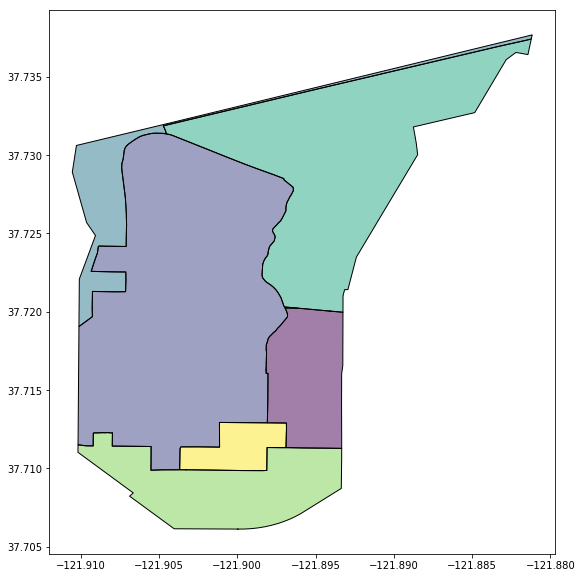

In [118]:
apns = new_parcels.apn.unique()
new_parcels[new_parcels.apn == apns[0]].plot(figsize=(12, 10))

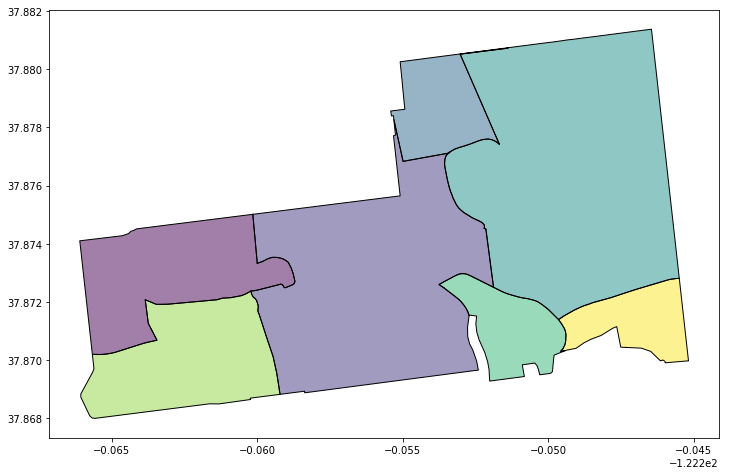

In [119]:
new_parcels[new_parcels.apn == apns[1]].plot(figsize=(12, 10))

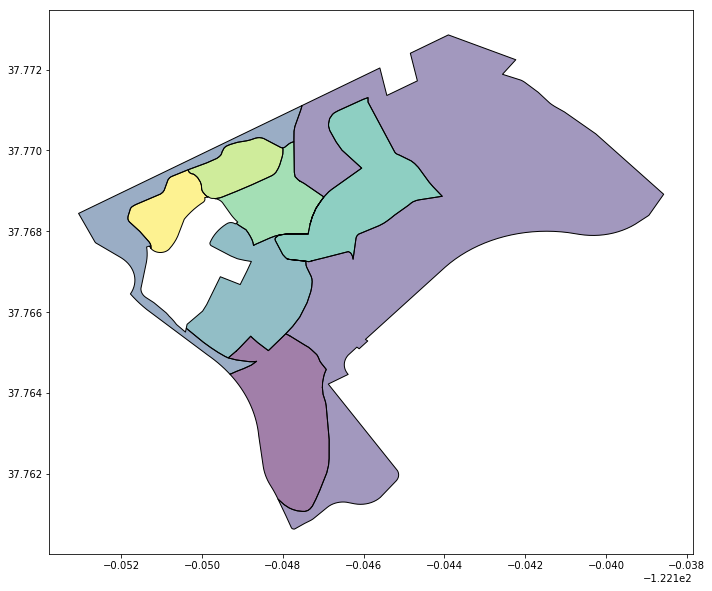

In [120]:
new_parcels[new_parcels.apn == apns[2]].plot(figsize=(12, 10))

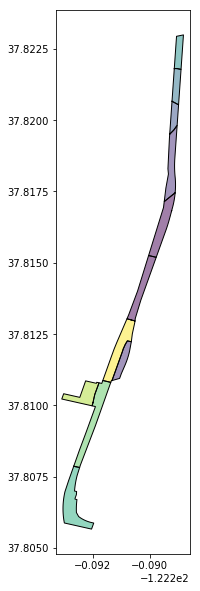

In [121]:
new_parcels[new_parcels.apn == apns[3]].plot(figsize=(12, 10))